## Práctica – Análisis de datos estructurados en Spark

#### Sistemas Sistribuidos de Proceamiento de Datos II    
   
  
##### David Rodríguez Rubio
##### Abril de 2023


In [4]:
# Load external packages programatically
# Here, we assume that you use Spark 3.2.1 or later (compiled against Scala 2.12)
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

packages = "com.databricks:spark-xml_2.12:0.16.0"

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages {0} pyspark-shell".format(packages)
)

In [5]:
os.environ["PYSPARK_SUBMIT_ARGS"]

'--packages com.databricks:spark-xml_2.12:0.16.0 pyspark-shell'

In [6]:
#Ruta de trabajo
%pwd

'/home/jovyan/work/0_Practica'

###### Este código utiliza la API de Spark para crear una sesión de Spark, que permite interactuar con los recursos de Spark y realizar operaciones en un cluster de Spark.

* Define la sesión de Spark con la función SparkSession.builder()
* Especifica el modo de ejecución de Spark con el método .master(). En este caso, se está utilizando el modo "local", lo que significa que se ejecutará en una sola máquina utilizando todos los núcleos disponibles. El asterisco en local[*] significa que Spark utilizará todos los núcleos disponibles en la máquina.
* Configura el número de núcleos de CPU que se utilizarán en la ejecución de Spark con el método .config(). En este caso, se está estableciendo en 1 el número de núcleos que el driver de Spark puede utilizar.
* Establece el nombre de la aplicación Spark con el método .appName(). 
* Crea una sesión de Spark con el método .getOrCreate(). El método getOrCreate() en la creación de una instancia de SparkSession en Spark tiene el propósito de obtener una sesión de Spark existente o crear una nueva si aún no existe. Si ya existe una sesión de Spark en el mismo contexto (ya sea en la misma aplicación o en la misma máquina), el método getOrCreate() retornará la sesión existente en lugar de crear una nueva. Esto es útil para compartir una misma sesión entre diferentes partes de una aplicación Spark, lo que puede mejorar el rendimiento. 

Una vez que se ha creado la sesión de Spark, se puede utilizar la API de Spark para cargar datos, realizar transformaciones y realizar operaciones en el cluster de Spark.

In [7]:
#Librerías

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


from pyspark.sql import functions as func

In [8]:
spark = (SparkSession.builder
    .master("local[*]")
    .config("spark.driver.cores", 1)
    .appName("proyecto_airnb")
    .getOrCreate())
spark



In [9]:
#Librerías

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


from pyspark.sql import functions as func

#### Lectura de datos

Previamente un vistazo el fichero csv en bruto

In [10]:
%system head -n 2 ../0_Practica/train.csv

['id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds',
 '6901257,5.010635294096256,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the loveliest neighborhood in Brooklyn. Blocks from the promenade and Brooklyn Bridge Park, with their stunning views of Manhattan, and from the great shopping and food.",2016-06-18,t,t,,2012-03-26,f,2016-07-18,40.696523629970756,-73.99161684624262,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7c

In [7]:
#Se comprobo que había saltos de línea y de carro, se hizo alguna prueba para sustituir el fichero en bruto estos saltos por vacía
# Fueron pruebas simplemente de culturilla para ver el potencial de %system

#%system sed -i 's/\r//g' ../0_Practica/train.csv
#%system sed -i 's/\n//g' ../0_Practica/train.csv
#%system sed -i 's/\n\n\n//g' ../0_Practica/train.csv


##### Esquema de estructura de datos del fichero de train

Página de apoyo:  
        https://spark.apache.org/docs/latest/sql-ref-datatypes.html


Bed y bedrooms se ve que tienen un decimal, pero todos tienen valor 0, por lo que se declara como ByteType, entero "pequeñito", en vez de flotante. Si es un proyecto a largo plazo habría que informarse si es posible que pueda haber decimales y si es así, declararla como flotante, si se quiere ser conservador o no vas a tener información de la procedencia, se podría declarar como tal

host_response_rate y review_scores_rating son ratios inferiores a 100 aunque tienen decimal, todos son cero, se puedo aplicar la lógica anterior.

In [10]:
airbnb_esquema_train = StructType([
                            StructField('id',IntegerType(), False), 
                            StructField('log_price',DoubleType(), False), 
                            StructField('property_type',StringType(), False), 
                            StructField('room_type',StringType(), False), 
                            StructField('amenities',StringType(), False), 
                            StructField('accommodates',ByteType(), False), 
                            StructField('bathrooms',FloatType(), False), 
                            StructField('bed_type',StringType(), False), 
                            StructField('cancellation_policy',StringType(), False), 
                            StructField('cleaning_fee',BooleanType(), False), 
                            StructField('city',StringType(), False), 
                            StructField('description',StringType(), False), 
                            StructField('first_review',DateType(), False), 
                            StructField('host_has_profile_pic',StringType(), False), 
                            StructField('host_identity_verified',StringType(), False), 
                            StructField('host_response_rate',StringType(), False), 
                            StructField('host_since',DateType(), False), 
                            StructField('instant_bookable',StringType(), False), 
                            StructField('last_review',DateType(), False), 
                            StructField('latitude',DoubleType(), False), 
                            StructField('longitude',DoubleType(), False), 
                            StructField('name',StringType(), False), 
                            StructField('neighbourhood',StringType(), False), 
                            StructField('number_of_reviews',IntegerType(), False), 
                            StructField('review_scores_rating',FloatType(), False), 
                            StructField('thumbnail_url',StringType(), False), 
                            StructField('zipcode',StringType(), False), 
                            StructField('bedrooms',FloatType(), False), 
                            StructField('beds',FloatType(), False)
                            ])


In [11]:
# Se comprueba que es valida la estructura del train para la de test (no hay ninguna "trampita", por lo menos no la he visto)
# Como sucede en los ficheros de Kaggle, en el fichero de test falta la variable a predecir, ya que en este tipo de retos es lo habitual.
# Por lo tanto en este reto se quería predecir el log-precio.

airbnb_esquema_test = StructType([
                            StructField('id',IntegerType(), False), 

                            StructField('property_type',StringType(), False), 
                            StructField('room_type',StringType(), False), 
                            StructField('amenities',StringType(), False), 
                            StructField('accommodates',ByteType(), False), 
                            StructField('bathrooms',FloatType(), False), 
                            StructField('bed_type',StringType(), False), 
                            StructField('cancellation_policy',StringType(), False), 
                            StructField('cleaning_fee',BooleanType(), False), 
                            StructField('city',StringType(), False), 
                            StructField('description',StringType(), False), 
                            StructField('first_review',DateType(), False), 
                            StructField('host_has_profile_pic',StringType(), False), 
                            StructField('host_identity_verified',StringType(), False), 
                            StructField('host_response_rate',StringType(), False), 
                            StructField('host_since',DateType(), False), 
                            StructField('instant_bookable',StringType(), False), 
                            StructField('last_review',DateType(), False), 
                            StructField('latitude',DoubleType(), False), 
                            StructField('longitude',DoubleType(), False), 
                            StructField('name',StringType(), False), 
                            StructField('neighbourhood',StringType(), False), 
                            StructField('number_of_reviews',IntegerType(), False), 
                            StructField('review_scores_rating',FloatType(), False), 
                            StructField('thumbnail_url',StringType(), False), 
                            StructField('zipcode',StringType(), False), 
                            StructField('bedrooms',FloatType(), False), 
                            StructField('beds',FloatType(), False)
                            ])


In [12]:
#Lectura de datos para fichero de train y de test con el esquema de datos inicial

airbnb_train = (spark.read.option("header", "true")
                .option("quote", "\"")  # Tuning escape double quotes
                .option("escape", "\"") # Tuning escape double quotes
                .option("multiLine", "true") # Tuning escape double quotes, los satos de línea los considera un registro

                .csv("train.csv", schema=airbnb_esquema_train
                ))

airbnb_test = (spark.read.option("header", "true")
                .option("quote", "\"")  # Tuning escape double quotes
                .option("escape", "\"") # Tuning escape double quotes
                .option("multiLine", "true") # Tuning escape double quotes
                .option("parserLib", "univocity") # Biblioteca de análisis sintáctico, univocity es una biblioteca para leer archivos CSV de manera más rápida y eficiente

                .csv("test.csv", schema=airbnb_esquema_test
                ))


In [9]:
airbnb_train.show(3,vertical=True)

-RECORD 0--------------------------------------
 id                     | 6901257              
 log_price              | 5.010635294096256    
 property_type          | Apartment            
 room_type              | Entire home/apt      
 amenities              | {"Wireless Intern... 
 accommodates           | 3                    
 bathrooms              | 1.0                  
 bed_type               | Real Bed             
 cancellation_policy    | strict               
 cleaning_fee           | true                 
 city                   | NYC                  
 description            | Beautiful, sunlit... 
 first_review           | 2016-06-18           
 host_has_profile_pic   | t                    
 host_identity_verified | t                    
 host_response_rate     | null                 
 host_since             | 2012-03-26           
 instant_bookable       | f                    
 last_review            | 2016-07-18           
 latitude               | 40.69652362997

##### Visualizaciones de train

In [10]:
airbnb_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- accommodates: byte (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: date (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- n

In [11]:
#Otra forma de ver los tipos de las columnas, como en python tradicional

airbnb_train.dtypes

[('id', 'int'),
 ('log_price', 'double'),
 ('property_type', 'string'),
 ('room_type', 'string'),
 ('amenities', 'string'),
 ('accommodates', 'tinyint'),
 ('bathrooms', 'float'),
 ('bed_type', 'string'),
 ('cancellation_policy', 'string'),
 ('cleaning_fee', 'boolean'),
 ('city', 'string'),
 ('description', 'string'),
 ('first_review', 'date'),
 ('host_has_profile_pic', 'string'),
 ('host_identity_verified', 'string'),
 ('host_response_rate', 'string'),
 ('host_since', 'date'),
 ('instant_bookable', 'string'),
 ('last_review', 'date'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('name', 'string'),
 ('neighbourhood', 'string'),
 ('number_of_reviews', 'int'),
 ('review_scores_rating', 'float'),
 ('thumbnail_url', 'string'),
 ('zipcode', 'string'),
 ('bedrooms', 'float'),
 ('beds', 'float')]

In [12]:
airbnb_train.show(5)

+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+----+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+------------------+-------------------+--------------------+----------------+-----------------+--------------------+--------------------+-------+--------+----+
|      id|         log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|          latitude|          longitude|                name|   neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|beds|
+--------+------------------+-------------+---------------+--------------------+------------+---------+---

In [13]:
#Devolvemos una lista con "n" elementos del RDD o DataFrame
airbnb_train.take(3)

[Row(id=6901257, log_price=5.010635294096256, property_type='Apartment', room_type='Entire home/apt', amenities='{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}', accommodates=3, bathrooms=1.0, bed_type='Real Bed', cancellation_policy='strict', cleaning_fee=True, city='NYC', description='Beautiful, sunlit brownstone 1-bedroom in the loveliest neighborhood in Brooklyn. Blocks from the promenade and Brooklyn Bridge Park, with their stunning views of Manhattan, and from the great shopping and food.', first_review=datetime.date(2016, 6, 18), host_has_profile_pic='t', host_identity_verified='t', host_response_rate=None, host_since=datetime.date(2012, 3, 26), instant_bookable='f', last_review=datetime.date(2016, 7, 18), latitude=40.696523629970756, longitude=-73.99161684624262, name='Beautiful brownstone 1-bedroom', neighbourhood='Brooklyn Heights', number_of_reviews=2, review_scores_rati

In [222]:
airbnb_train.show(5,vertical=True)

-RECORD 0--------------------------------------
 id                     | 6901257              
 log_price              | 5.010635294096256    
 property_type          | Apartment            
 room_type              | Entire home/apt      
 amenities              | {"Wireless Intern... 
 accommodates           | 3                    
 bathrooms              | 1.0                  
 bed_type               | Real Bed             
 cancellation_policy    | strict               
 cleaning_fee           | true                 
 city                   | NYC                  
 description            | Beautiful, sunlit... 
 first_review           | 2016-06-18           
 host_has_profile_pic   | t                    
 host_identity_verified | t                    
 host_response_rate     | null                 
 host_since             | 2012-03-26           
 instant_bookable       | f                    
 last_review            | 2016-07-18           
 latitude               | 40.69652362997

In [223]:
#Mostrar por conjunto de variables
#cols1 = airbnb_train.columns[airbnb_train.columns.index('id'):airbnb_train.columns.index('bed_type')+1]
cols1 = airbnb_train.columns[0:8]
cols2 = airbnb_train.columns[9:15]
cols3 = airbnb_train.columns[16:24]
cols4 = airbnb_train.columns[25:]
print(cols1)
print(cols2)
print(cols3)
print(cols4)

['id', 'log_price', 'property_type', 'room_type', 'amenities', 'accommodates', 'bathrooms', 'bed_type']
['cleaning_fee', 'city', 'description', 'first_review', 'host_has_profile_pic', 'host_identity_verified']
['host_since', 'instant_bookable', 'last_review', 'latitude', 'longitude', 'name', 'neighbourhood', 'number_of_reviews']
['thumbnail_url', 'zipcode', 'bedrooms', 'beds']


In [224]:
#airnb_train.select(0:8).show(5)
airbnb_train.select(cols1).show(5)

+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+
|      id|         log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|
+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+
| 6901257| 5.010635294096256|    Apartment|Entire home/apt|{"Wireless Intern...|           3|      1.0|Real Bed|
| 6304928|5.1298987149230735|    Apartment|Entire home/apt|{"Wireless Intern...|           7|      1.0|Real Bed|
| 7919400| 4.976733742420574|    Apartment|Entire home/apt|{TV,"Cable TV","W...|           5|      1.0|Real Bed|
|13418779| 6.620073206530356|        House|Entire home/apt|{TV,"Cable TV",In...|           4|      1.0|Real Bed|
| 3808709|  4.74493212836325|    Apartment|Entire home/apt|{TV,Internet,"Wir...|           2|      1.0|Real Bed|
+--------+------------------+-------------+---------------+--------------------+------------+---

In [225]:
airbnb_train.select(cols2).show(5)

+------------+----+--------------------+------------+--------------------+----------------------+
|cleaning_fee|city|         description|first_review|host_has_profile_pic|host_identity_verified|
+------------+----+--------------------+------------+--------------------+----------------------+
|        true| NYC|Beautiful, sunlit...|  2016-06-18|                   t|                     t|
|        true| NYC|Enjoy travelling ...|  2017-08-05|                   t|                     f|
|        true| NYC|The Oasis comes c...|  2017-04-30|                   t|                     t|
|        true|  SF|This light-filled...|        null|                   t|                     t|
|        true|  DC|Cool, cozy, and c...|  2015-05-12|                   t|                     t|
+------------+----+--------------------+------------+--------------------+----------------------+
only showing top 5 rows



In [206]:
airbnb_train.select(cols3).show(5)

+----------+----------------+-----------+------------------+-------------------+--------------------+----------------+-----------------+
|host_since|instant_bookable|last_review|          latitude|          longitude|                name|   neighbourhood|number_of_reviews|
+----------+----------------+-----------+------------------+-------------------+--------------------+----------------+-----------------+
|2012-03-26|               f| 2016-07-18|40.696523629970756| -73.99161684624262|Beautiful brownst...|Brooklyn Heights|                2|
|2017-06-19|               t| 2017-09-23|40.766115415949685| -73.98903992265213|Superb 3BR Apt Lo...|  Hell's Kitchen|                6|
|2016-10-25|               t| 2017-09-14| 40.80810998936211| -73.94375584395794|    The Garden Oasis|          Harlem|               10|
|2015-04-19|               f|       null|37.772004482560774|-122.43161868239788|Beautiful Flat in...|    Lower Haight|                0|
|2015-03-01|               t| 2017-01-22|

In [207]:
airbnb_train.select(cols4).show(5)

+--------------------+-------+--------+----+
|       thumbnail_url|zipcode|bedrooms|beds|
+--------------------+-------+--------+----+
|https://a0.muscac...|  11201|     1.0| 1.0|
|https://a0.muscac...|  10019|     3.0| 3.0|
|https://a0.muscac...|  10027|     1.0| 3.0|
|https://a0.muscac...|   null|     2.0| 2.0|
|                null|  20009|     0.0| 1.0|
+--------------------+-------+--------+----+
only showing top 5 rows



In [234]:
#Conteo de missing en train
columnNames = airbnb_train.columns
missingCounts = [sum(when(col(colName).isNull(), 1).otherwise(0)).alias(colName) for colName in columnNames]

airbnb_train.agg(*missingCounts).show(vertical=True)

-RECORD 0-----------------------
 id                     | 0     
 log_price              | 0     
 property_type          | 0     
 room_type              | 0     
 amenities              | 0     
 accommodates           | 0     
 bathrooms              | 200   
 bed_type               | 0     
 cancellation_policy    | 0     
 cleaning_fee           | 0     
 city                   | 0     
 description            | 0     
 first_review           | 15864 
 host_has_profile_pic   | 188   
 host_identity_verified | 188   
 host_response_rate     | 18299 
 host_since             | 188   
 instant_bookable       | 0     
 last_review            | 15827 
 latitude               | 0     
 longitude              | 0     
 name                   | 0     
 neighbourhood          | 6872  
 number_of_reviews      | 0     
 review_scores_rating   | 16722 
 thumbnail_url          | 8216  
 zipcode                | 966   
 bedrooms               | 91    
 beds                   | 131   



##### Visualizaciones de test

In [226]:
airbnb_test.printSchema()

root
 |-- id: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- accommodates: byte (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: date (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- number_of_reviews: integer (nullable = tru

In [210]:
airbnb_test.dtypes

[('id', 'int'),
 ('property_type', 'string'),
 ('room_type', 'string'),
 ('amenities', 'string'),
 ('accommodates', 'tinyint'),
 ('bathrooms', 'float'),
 ('bed_type', 'string'),
 ('cancellation_policy', 'string'),
 ('cleaning_fee', 'boolean'),
 ('city', 'string'),
 ('description', 'string'),
 ('first_review', 'date'),
 ('host_has_profile_pic', 'string'),
 ('host_identity_verified', 'string'),
 ('host_response_rate', 'string'),
 ('host_since', 'date'),
 ('instant_bookable', 'string'),
 ('last_review', 'date'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('name', 'string'),
 ('neighbourhood', 'string'),
 ('number_of_reviews', 'int'),
 ('review_scores_rating', 'tinyint'),
 ('thumbnail_url', 'string'),
 ('zipcode', 'int'),
 ('bedrooms', 'float'),
 ('beds', 'float')]

In [211]:
airbnb_test.show(5)

+-------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+----+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+------------------+-------------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+--------+----+
|     id|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|          latitude|          longitude|                name|    neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|beds|
+-------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+----+--------------

In [212]:
#Devolvemos una lista con "n" elementos del RDD o DataFrame
airbnb_test.take(5)

[Row(id=3895911, property_type='Apartment', room_type='Private room', amenities='{TV,"Cable TV",Kitchen,"Free parking on premises",Breakfast,"Elevator in building",Heating,Washer,Dryer,"Smoke detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}', accommodates=2, bathrooms=1.0, bed_type='Real Bed', cancellation_policy='flexible', cleaning_fee=True, city='LA', description="Close to SM beaches, 3rd Street Promenade, SM Pier & Venice, Montana Avenue, St. John's and SM Hospitals. You’ll love my place because of it's perfect location in the heart of Santa Monica. It's walking distance to great restaurants, coffee shops, bus lines, beaches, bike rentals, shopping, markets, drug stores, theaters, and more! You will have your own clean and private separate wing with a private bath and shower.  It's great for couples, solo adve

In [227]:
airbnb_test.show(5,vertical=True)

-RECORD 0--------------------------------------
 id                     | 3895911              
 property_type          | Apartment            
 room_type              | Private room         
 amenities              | {TV,"Cable TV",Ki... 
 accommodates           | 2                    
 bathrooms              | 1.0                  
 bed_type               | Real Bed             
 cancellation_policy    | flexible             
 cleaning_fee           | true                 
 city                   | LA                   
 description            | Close to SM beach... 
 first_review           | 2016-10-23           
 host_has_profile_pic   | t                    
 host_identity_verified | f                    
 host_response_rate     | 100%                 
 host_since             | 2016-08-13           
 instant_bookable       | f                    
 last_review            | 2017-02-26           
 latitude               | 34.028372378220894   
 longitude              | -118.494449401

In [132]:
#Mostrar por conjunto de variables
#cols1 = airbnb_test.columns[airbnb_test.columns.index('id'):airbnb_test.columns.index('bed_type')+1]
cols1 = airbnb_test.columns[0:8]
cols2 = airbnb_test.columns[9:15]
cols3 = airbnb_test.columns[16:24]
cols4 = airbnb_test.columns[25:]


In [133]:
airbnb_test.select(cols1).show(5)

+-------+-------------+---------------+--------------------+------------+---------+--------+-------------------+
|     id|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|
+-------+-------------+---------------+--------------------+------------+---------+--------+-------------------+
|3895911|    Apartment|   Private room|{TV,"Cable TV",Ki...|           2|      1.0|Real Bed|           flexible|
|9710289|    Apartment|Entire home/apt|{TV,"Cable TV","W...|           3|      1.0|Real Bed|           moderate|
|9051635|    Apartment|   Private room|{"Wireless Intern...|           1|      1.0|Real Bed|           moderate|
| 708374|    Apartment|Entire home/apt|{TV,"Cable TV",In...|           1|      1.0|Real Bed|             strict|
| 626296|    Apartment|Entire home/apt|{TV,Internet,"Wir...|           2|      1.0|Real Bed|           flexible|
+-------+-------------+---------------+--------------------+------------+---------+--------+----

In [134]:
airbnb_test.select(cols2).show(5)

+----+--------------------+------------+--------------------+----------------------+------------------+
|city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|
+----+--------------------+------------+--------------------+----------------------+------------------+
|  LA|Close to SM beach...|  2016-10-23|                   t|                     f|              null|
| NYC|This apartment wi...|  2016-09-12|                   t|                     t|              null|
|  SF|Spacious 1 bedroo...|  2016-11-13|                   t|                     t|              null|
|  LA|Very clean 1 Bedr...|  2015-11-01|                   t|                     t|              null|
| NYC|My apartment is a...|        null|                   t|                     t|              null|
+----+--------------------+------------+--------------------+----------------------+------------------+
only showing top 5 rows



In [135]:
airbnb_test.select(cols3).show(5)

+----------------+-----------+------------------+-------------------+--------------------+-----------------+-----------------+--------------------+
|instant_bookable|last_review|          latitude|          longitude|                name|    neighbourhood|number_of_reviews|review_scores_rating|
+----------------+-----------+------------------+-------------------+--------------------+-----------------+-----------------+--------------------+
|               f| 2017-02-26|34.028372378220894|-118.49444940110756|Santa Monica Priv...|     Santa Monica|                6|                null|
|               f| 2016-10-16|40.720380083292326| -73.94232924998272|Bright, charming ...|     Williamsburg|                2|                null|
|               f| 2016-11-17| 37.78543402316095| -122.4702842230142|Private room in c...|Richmond District|                2|                null|
|               f| 2017-03-01| 33.97602643531822|-118.46347122639445|Marina del Rey Be...|   Marina Del Rey|    

In [136]:
airbnb_test.select(cols4).show(5)

+-------+--------+----+
|zipcode|bedrooms|beds|
+-------+--------+----+
|  90403|    null|null|
|  11222|    null|null|
|  94118|    null|null|
|  90292|    null|null|
|  10014|    null|null|
+-------+--------+----+
only showing top 5 rows



In [235]:
#Conteo de missing en test
columnNames = airbnb_test.columns
missingCounts = [sum(when(col(colName).isNull(), 1).otherwise(0)).alias(colName) for colName in columnNames]

airbnb_test.agg(*missingCounts).show(vertical=True)

-RECORD 0----------------------
 id                     | 0    
 property_type          | 0    
 room_type              | 0    
 amenities              | 0    
 accommodates           | 0    
 bathrooms              | 79   
 bed_type               | 0    
 cancellation_policy    | 0    
 cleaning_fee           | 0    
 city                   | 0    
 description            | 14   
 first_review           | 5436 
 host_has_profile_pic   | 55   
 host_identity_verified | 55   
 host_response_rate     | 6306 
 host_since             | 55   
 instant_bookable       | 0    
 last_review            | 5425 
 latitude               | 0    
 longitude              | 0    
 name                   | 5    
 neighbourhood          | 2465 
 number_of_reviews      | 0    
 review_scores_rating   | 5717 
 thumbnail_url          | 2859 
 zipcode                | 321  
 bedrooms               | 28   
 beds                   | 46   



#### Más validaciones

In [137]:
#Conteo de tabla spark
print("Conteo de registros en train",airbnb_train.count())
print("Conteo de registros en test",airbnb_test.count())

porcentaje_test=((airbnb_test.count() / (airbnb_train.count() + airbnb_test.count())) * 100)
print("{:.2f}% de test".format(porcentaje_test))

Conteo de registros en train 74111
Conteo de registros en test 25458
25.57% de test


In [138]:
#Número de variables
print("Variables en train",len(airbnb_train.columns))
print("Variables en test",len(airbnb_test.columns))

Variables en train 29
Variables en test 28


In [139]:
#Conteos ¿Hay duplicados?
print("Registros únicos:")
airbnb_train.agg(countDistinct('id')).show()
print("Registros fichero:",airbnb_train.count())
#74097

Registros únicos:
+---------+
|count(id)|
+---------+
|    74111|
+---------+

Registros fichero: 74111


No hay duplicados!!!

Así es como vi que había saltos de línea en el fichero y se estaba importando mal de primeras, por lo que tuve que incluir nuevas sentencias para poder importarlo correctamente.

In [236]:

# Gracias a ver que había duplicados vimos que en estos registros había saltos de línea y de carro
# Y se pudo tomar una solución a estos saltos, multiline true.


airbnb_train.filter(airbnb_train.id==18915873).select("zipcode","bedrooms","beds").show()
airbnb_train.filter(airbnb_train.id==19086890).select("amenities","zipcode","bedrooms","beds").show()

#El campo zipcode a parte de tener estos saltos, hay códigos con un decimal, textos, rangos de codigo, esto a la hora trabajar con ellos, 
# que tomar decisiones, de eliminar registros, corregirlos,...

+--------------------+--------+----+
|             zipcode|bedrooms|beds|
+--------------------+--------+----+
|95202\r\r\r\r\r\n...|     1.0| 1.0|
+--------------------+--------+----+

+--------------------+--------------------+--------+----+
|           amenities|             zipcode|bedrooms|beds|
+--------------------+--------------------+--------+----+
|{TV,Internet,"Wir...|11249\r\r\r\r\r\n...|     1.0| 1.0|
+--------------------+--------------------+--------+----+



##### Modificamos algunos datos para dar un formato de tipo correcto

##### Campo: amenities

In [14]:
#Corregimos el campo amenities que tiene una cadena de items, y lo vamos a considerar una lista de texto

#Sustitiumos las comillas dobles por vacío y las llaves por corchetes. 
#Se intento hacer por pasos, es decir primero cambiar comillas y luego corchetes y no lo hacía bien, hay que ha hacer en un paso
# Es claro que es más óptimo en un paso, pero para tener más control y en pruebas... 
airbnb_train = airbnb_train.withColumn("amenities", regexp_replace('amenities', r"""[{"}]""", '') )

#Trasformamos a una lista el cmapo
airbnb_train = airbnb_train.withColumn("amenities", split(airbnb_train.amenities, ","))

#En test
airbnb_test = airbnb_test.withColumn("amenities", regexp_replace('amenities', r"""[{"}]""", '') )

#Trasformamos a una lista el cmapo
airbnb_test = airbnb_test.withColumn("amenities", split(airbnb_test.amenities, ","))


In [15]:
#Comprobación visual del campo, lo normal es mirar primero el esquema, pero dada la experiencia adquirida con este campo,
# lo hago al revés, el tema es que al hacer el cambio en el campo se me queda el campo a null pero el esquema se modificaba correctamente
# se debía principalmente a la "trampita" de las dobles comillas
airbnb_train.select("amenities").take(4)

[Row(amenities=['Wireless Internet', 'Air conditioning', 'Kitchen', 'Heating', 'Family/kid friendly', 'Essentials', 'Hair dryer', 'Iron', 'translation missing: en.hosting_amenity_50']),
 Row(amenities=['Wireless Internet', 'Air conditioning', 'Kitchen', 'Heating', 'Family/kid friendly', 'Washer', 'Dryer', 'Smoke detector', 'Fire extinguisher', 'Essentials', 'Shampoo', 'Hangers', 'Hair dryer', 'Iron', 'translation missing: en.hosting_amenity_50']),
 Row(amenities=['TV', 'Cable TV', 'Wireless Internet', 'Air conditioning', 'Kitchen', 'Breakfast', 'Buzzer/wireless intercom', 'Heating', 'Family/kid friendly', 'Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'Essentials', 'Shampoo', 'Hangers', 'Hair dryer', 'Iron', 'Laptop friendly workspace', 'translation missing: en.hosting_amenity_50']),
 Row(amenities=['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Kitchen', 'Indoor fireplace', 'Buzzer/wireless intercom', 'Heating', 'Washer', 'Dryer', 'Smoke detector', 'Carbon mon

In [16]:
# Comprobación visual del esquema de datos
airbnb_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- accommodates: byte (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: date (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-

In [17]:
airbnb_test.select("amenities").take(4)

[Row(amenities=['TV', 'Cable TV', 'Kitchen', 'Free parking on premises', 'Breakfast', 'Elevator in building', 'Heating', 'Washer', 'Dryer', 'Smoke detector', 'First aid kit', 'Safety card', 'Fire extinguisher', 'Essentials', 'Shampoo', 'Hangers', 'Hair dryer', 'Iron', 'Laptop friendly workspace', 'translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']),
 Row(amenities=['TV', 'Cable TV', 'Wireless Internet', 'Air conditioning', 'Kitchen', 'Gym', 'Elevator', 'Heating', 'Washer', 'Dryer', 'Smoke detector', 'Carbon monoxide detector', 'Essentials', 'Hair dryer', 'Laptop friendly workspace', 'translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50', 'Self Check-In', 'Lockbox', 'Hot water', 'Bed linens']),
 Row(amenities=['Wireless Internet', 'Kitchen', 'Heating', 'Family/kid friendly', 'Smoke detector', 'Carbon monoxide detector', 'First aid kit', 'Essentials', 'Shampoo', 'Hair dryer', 'Laptop friendly workspace', 'transla

In [18]:
airbnb_test.printSchema()

root
 |-- id: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- accommodates: byte (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: date (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)

In [19]:
#Otra forma que se probo para hacer el cambio del campo a lista a través de funciones udf

'''
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType


def parse_string(string):
    return string.replace('{','').replace('}','').replace('"','').split(',')

# Registrar la función definida por el usuario como una función de Spark UDF
parse_string_udf = udf(parse_string, ArrayType(StringType()))

airnb_train = airnb_train.withColumn("amenities",parse_string_udf('amenities'))
'''
print("")

In [20]:
#Pruebas fallidas con las pistas que nos dejo Felipe....sin rencor!!!

# Use function from_json and the schemas above to parse the content of JSON columns,
# updating the general schema of the DataFrame and preserving the other columns
#airnb_train = (airnb_train.withColumn('amenities', from_json(col('amenities'), amenities_json_schema )) )
#airnb_train = airnb_train.withColumn('amenities', from_json(col('amenities'), ArrayType(StringType())))


##### Campo: review_scores_rating

In [21]:
# Quitamos el simbolo de %
airbnb_train = airbnb_train.withColumn("host_response_rate", regexp_replace('host_response_rate',"%", '') )
airbnb_test = airbnb_test.withColumn("host_response_rate", regexp_replace('host_response_rate',"%", '') )
     
#Cambiamos el tipo de datos
airbnb_train = airbnb_train.withColumn('host_response_rate', airbnb_train['host_response_rate'].cast(DoubleType()))
airbnb_test = airbnb_test.withColumn('host_response_rate', airbnb_test['host_response_rate'].cast(DoubleType()))


In [22]:
airbnb_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- accommodates: byte (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: date (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_since: date (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-

In [23]:
airbnb_train.select("review_scores_rating").take(4)

[Row(review_scores_rating=100.0),
 Row(review_scores_rating=93.0),
 Row(review_scores_rating=92.0),
 Row(review_scores_rating=None)]

In [24]:
airbnb_test.printSchema()

root
 |-- id: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- accommodates: byte (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: date (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_since: date (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- last_review: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)

In [25]:
airbnb_test.select("review_scores_rating").take(4)

[Row(review_scores_rating=97.0),
 Row(review_scores_rating=80.0),
 Row(review_scores_rating=100.0),
 Row(review_scores_rating=94.0)]

#### Muestra aleatoria para hacer un breve EDA

In [22]:
# Prueba precaria de calculo... al no existir como en python un parámetro para indicar un número de muestra concreto, en este caso es porcentual 
# y con el porcentual no obtenemos el número exacto de la muestra...

muestra = airbnb_train.sample(fraction=((100*10.592)/airbnb_train.count()), seed=20)
muestra.count()

1002

In [26]:
# Cálculo exacto de la muestra ...como casi todo en esta vida siempre las cosas se pueden hacer de varias formas

airbnb_train=airbnb_train.withColumn("aleatorio", rand(seed=20))


muestra=(airbnb_train
         .orderBy(desc('aleatorio'))
         .limit(1000)
         .drop('aleatorio')
         )
airbnb_train = airbnb_train.drop('aleatorio')


In [27]:
muestra.count()

1000

In [28]:
df_airbnb_train=muestra.toPandas()


In [29]:
#Definimos librerías de python
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [27]:
df_airbnb_train.shape

(1000, 29)

In [28]:
df_airbnb_train.head(3)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,7810784,4.744932,Apartment,Entire home/apt,"[Internet, Wireless Internet, Air conditioning...",2,1.0,Real Bed,flexible,False,...,34.162239,-118.430518,Studio for May & June,None,0,NaN,https://a0.muscache.com/im/pictures/07d0f4a1-9...,None,1.0,1.0
1,21173707,3.367296,Dorm,Shared room,"[Internet, Wireless Internet, Kitchen, Heating...",1,NaN,Real Bed,strict,False,...,37.794184,-122.405819,Shelli's Student Home4(1 Month Min),Chinatown,6,100.0,https://a0.muscache.com/im/pictures/5676690/30...,94108,1.0,1.0
2,21000720,4.700480,Apartment,Private room,"[TV, Cable TV, Internet, Wireless Internet, Ai...",3,1.0,Real Bed,moderate,False,...,40.720904,-73.959351,Williamsburg on Wythe - Private BR+,Williamsburg,33,96.0,https://a0.muscache.com/im/pictures/4304d270-c...,11211.0,1.0,1.0


#### Numéricas

In [29]:
df_airbnb_train.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.97, 0.99])

,id,log_price,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,1.000000e+03,1000.000000,1000.000000,997.000000,751.000000,1000.000000,1000.000000,1000.000000,759.000000,999.000000,999.000000
mean,1.099036e+07,4.755794,3.093000,1.238215,95.376831,38.369652,-92.940766,21.977000,93.594200,1.256256,1.675676
std,6.166951e+06,0.742259,2.109218,0.596739,14.461183,3.111486,21.801312,42.542665,9.121508,0.826905,1.263374
min,1.096200e+04,2.944439,1.000000,0.000000,0.000000,33.715780,-122.503008,0.000000,20.000000,0.000000,1.000000
5%,6.710985e+05,3.663562,1.000000,1.000000,74.000000,33.986238,-122.417648,0.000000,80.000000,0.000000,1.000000
10%,1.733662e+06,3.910003,1.000000,1.000000,85.000000,34.039958,-118.530840,0.000000,85.000000,1.000000,1.000000
25%,5.874159e+06,4.248495,2.000000,1.000000,100.000000,34.111896,-118.339927,1.000000,91.000000,1.000000,1.000000
50%,1.168798e+07,4.653960,2.000000,1.000000,100.000000,40.651063,-77.013541,5.000000,96.000000,1.000000,1.000000
75%,1.642068e+07,5.177558,4.000000,1.000000,100.000000,40.741761,-73.956155,24.000000,100.000000,1.000000,2.000000
80%,1.698798e+07,5.298317,4.000000,1.500000,100.000000,40.763632,-73.947893,33.000000,100.000000,2.000000,2.000000


In [30]:
numeric_features = df_airbnb_train.select_dtypes(include=['number']).columns.tolist()


numeric_features.remove('id')
numeric_features.remove('latitude')
numeric_features.remove('longitude')
numeric_features

['log_price',
 'accommodates',
 'bathrooms',
 'host_response_rate',
 'number_of_reviews',
 'review_scores_rating',
 'bedrooms',
 'beds']

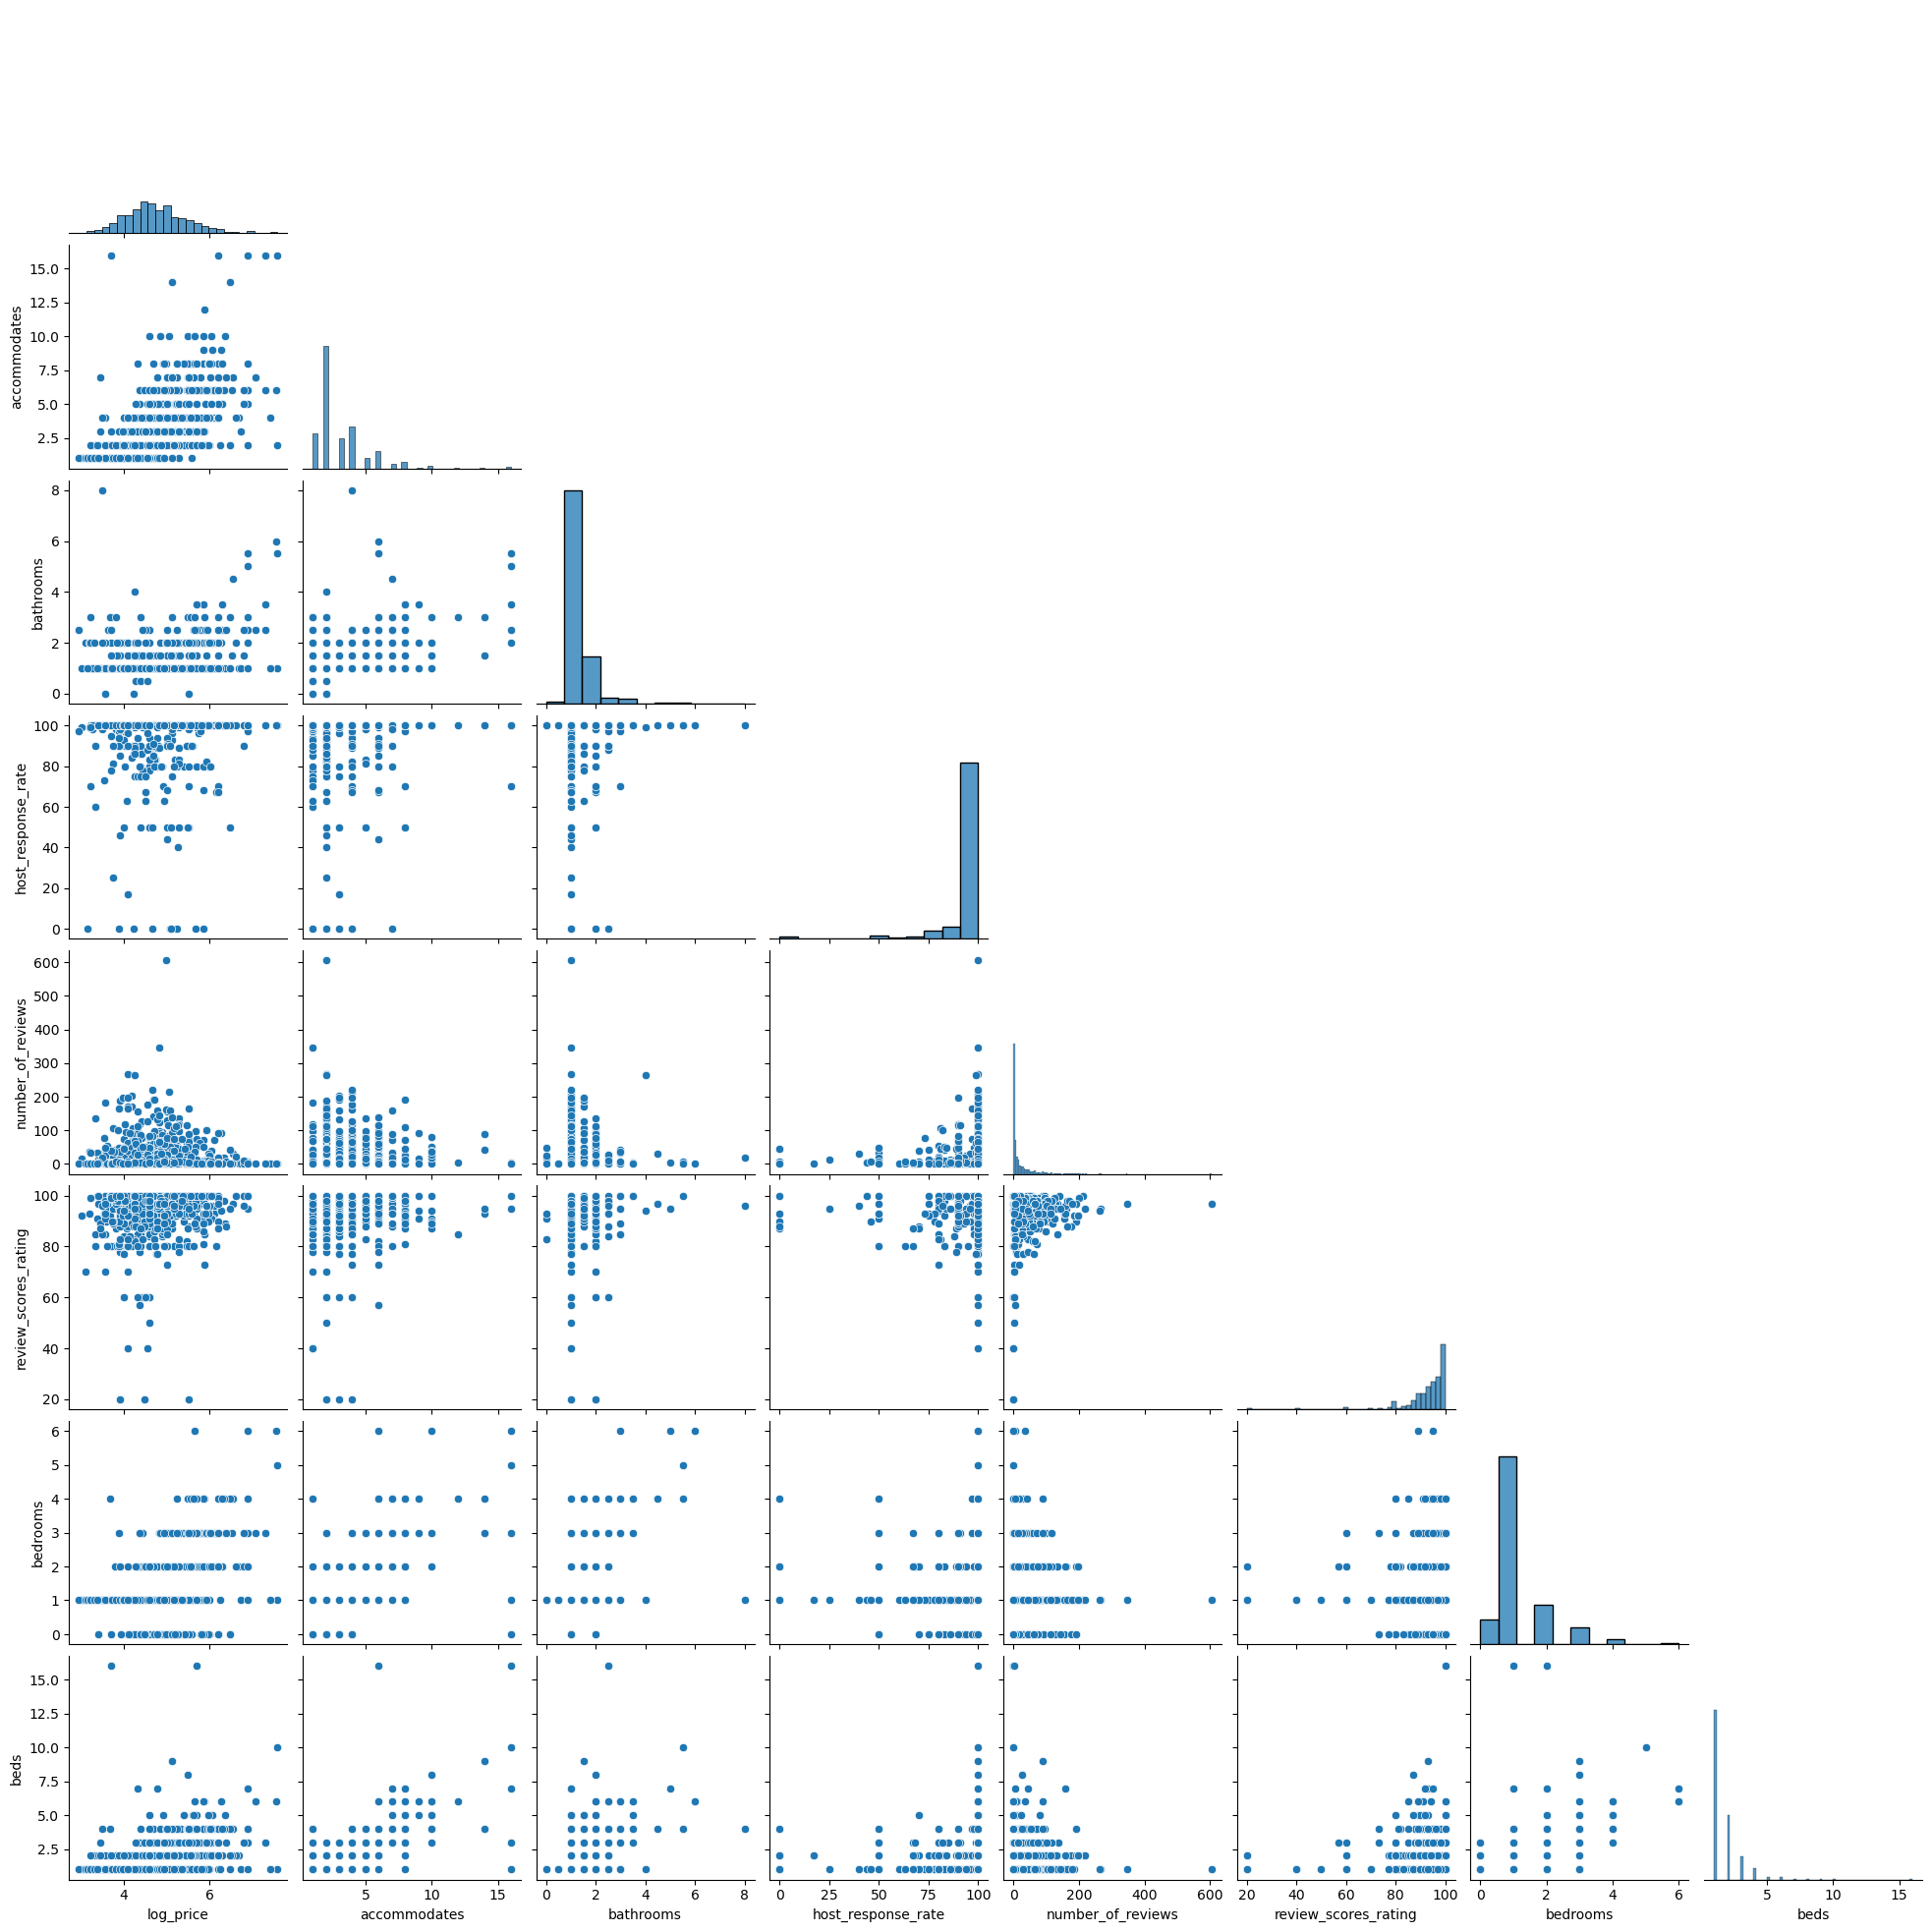

In [31]:
# Crear la matriz de gráficos de densidad con Seaborn

sns.pairplot(df_airbnb_train[numeric_features], corner=True)

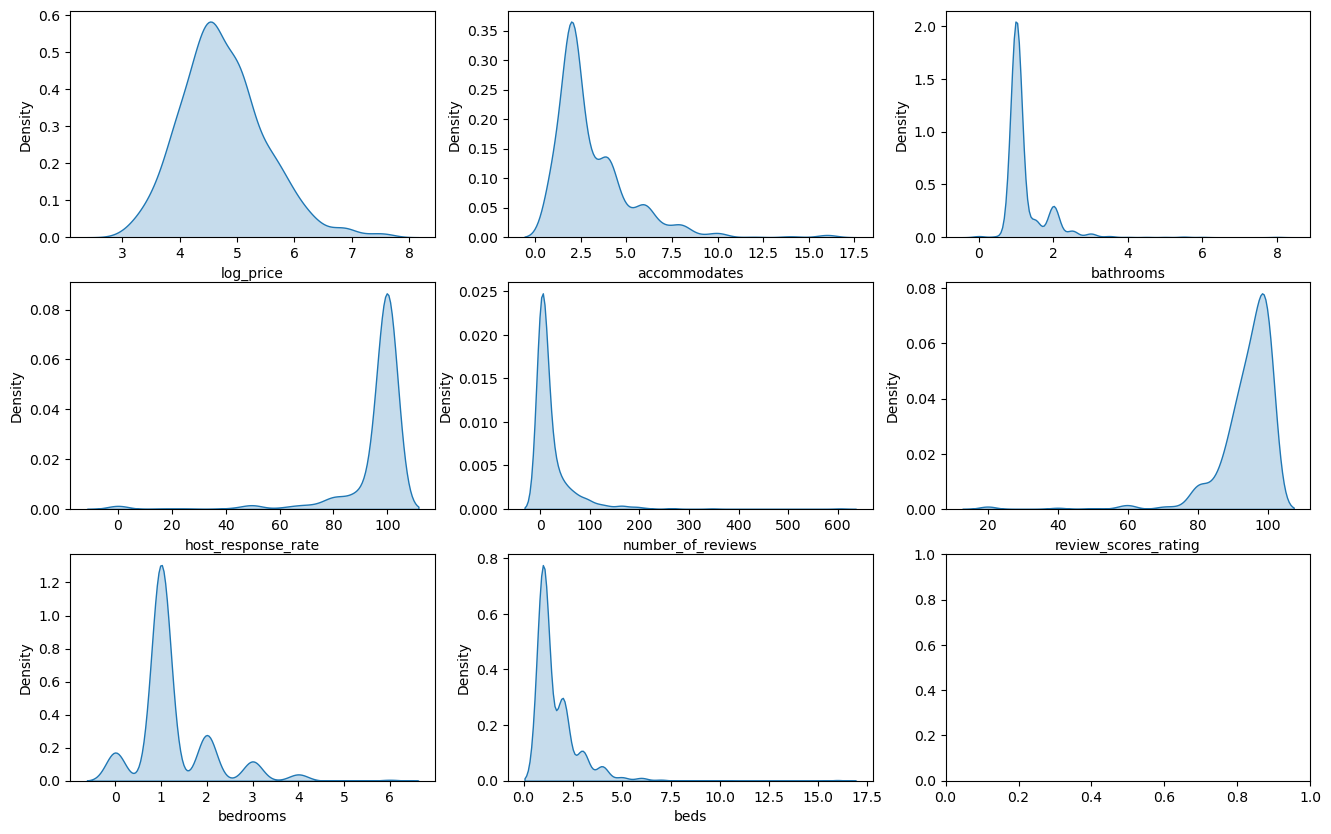

In [32]:
import matplotlib.pyplot as plt

# Crear la figura y los subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 10)) 
sns.set_style("darkgrid")
sns.kdeplot(df_airbnb_train["log_price"], fill=True, ax=axs[0,0])
sns.kdeplot(df_airbnb_train["accommodates"], fill=True, ax=axs[0,1])
sns.kdeplot(df_airbnb_train["bathrooms"], fill=True, ax=axs[0,2])
sns.kdeplot(df_airbnb_train["host_response_rate"], fill=True, ax=axs[1,0])
sns.kdeplot(df_airbnb_train["number_of_reviews"], fill=True, ax=axs[1,1])
sns.kdeplot(df_airbnb_train["review_scores_rating"], fill=True, ax=axs[1,2])
sns.kdeplot(df_airbnb_train["bedrooms"], fill=True, ax=axs[2,0])
sns.kdeplot(df_airbnb_train["beds"], fill=True, ax=axs[2,1])
plt.show()

#### Categoríacas/boolean

In [468]:
#Primer vistazo!!!
df_airbnb_train.describe(exclude="number")

,property_type,room_type,amenities,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,name,neighbourhood,thumbnail_url,zipcode
count,1000,1000,1000,1000,1000,1000,1000,1000,774,999,999,999,1000,775,1000,911,897,986
unique,17,3,987,5,4,2,6,1000,573,2,2,803,2,322,1000,251,897,313
top,Apartment,Entire home/apt,{},Real Bed,strict,True,NYC,Cozy and very quiet. Great location across fro...,2017-04-16,t,t,2016-04-25,f,2017-09-24,Studio for May & June,Williamsburg,https://a0.muscache.com/im/pictures/07d0f4a1-9...,11221
freq,652,533,9,973,401,733,426,1,7,995,672,4,742,18,1,44,1,29


In [565]:
categoricas_features = df_airbnb_train.select_dtypes(exclude=['number']).columns
categoricas_features

Index(['property_type', 'room_type', 'amenities', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'description',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_since', 'instant_bookable', 'last_review', 'name',
       'neighbourhood', 'thumbnail_url', 'zipcode'],
      dtype='object')

In [566]:
#categoricas_features = df_airbnb_train.select_dtypes(exclude=['number']).columns

categoricas_features=['property_type', 'room_type','bed_type','cancellation_policy','city','host_identity_verified', 'instant_bookable','cleaning_fee']


In [573]:
df_airbnb_train['host_identity_verified'] = df_airbnb_train['host_identity_verified'].replace("t", "True")
df_airbnb_train['host_identity_verified'] = df_airbnb_train['host_identity_verified'].replace("f", "False")
df_airbnb_train['host_identity_verified'] = df_airbnb_train['host_identity_verified'].replace("", "Desconocido")

df_airbnb_train['instant_bookable'] = df_airbnb_train['instant_bookable'].replace("t", "True")
df_airbnb_train['instant_bookable'] = df_airbnb_train['instant_bookable'].replace("f", "False")
df_airbnb_train['instant_bookable'] = df_airbnb_train['instant_bookable'].replace("", "Desconocido")




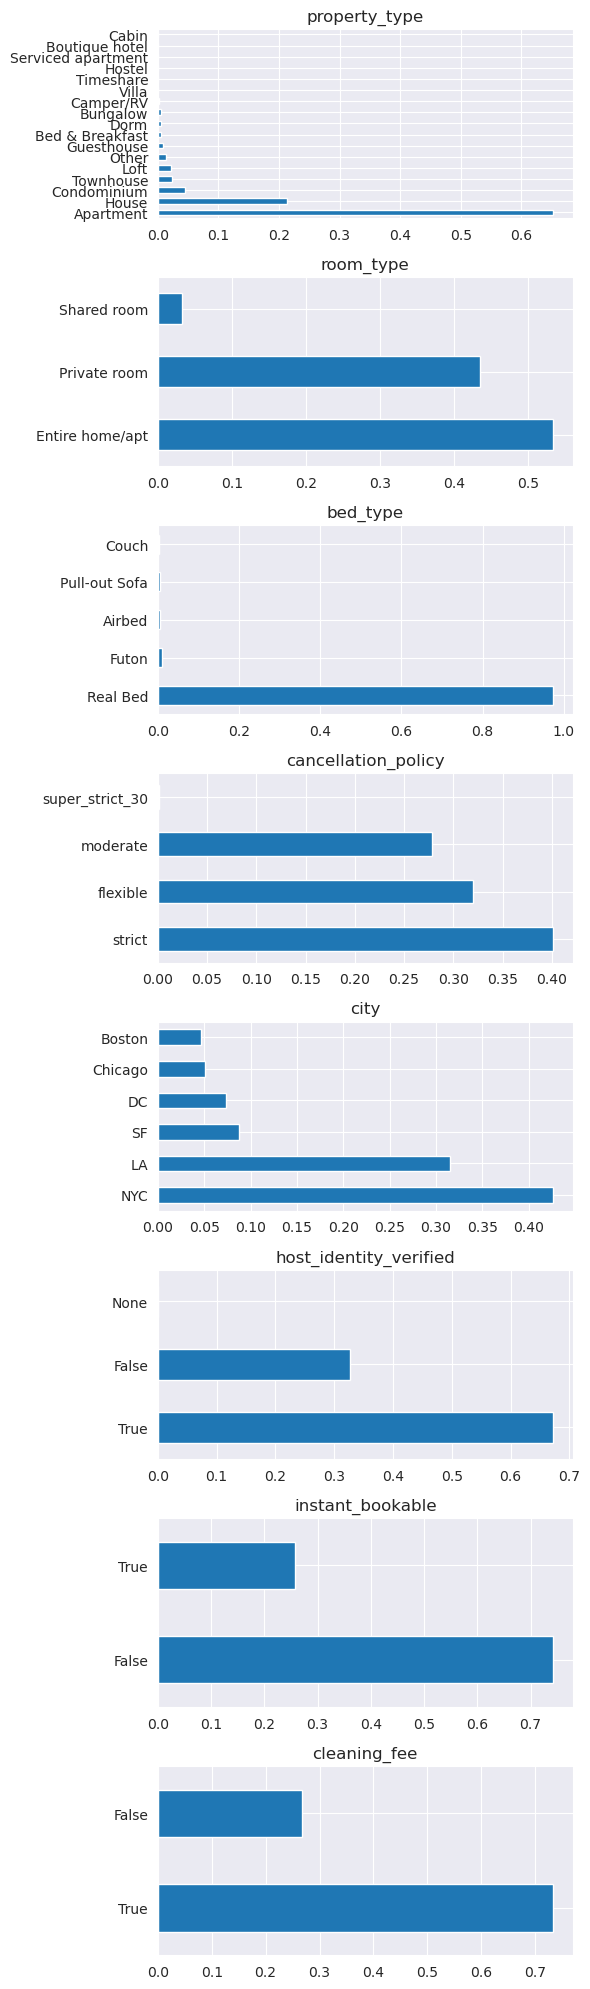

In [575]:
fig, ax = plt.subplots(ncols=1, nrows=len(categoricas_features), figsize=(6,20))

for i, feature in enumerate(categoricas_features):
    df_airbnb_train[feature].value_counts(normalize=True,dropna=False).plot(kind="barh", ax=ax[i])
    ax[i].set_title(feature)

fig.tight_layout()
fig.show()

##### Para utilizar la variable property_type en modelos tendríamos que intentar agrupar categorías por similitud y en el caso de que no se pudiera, las categorías con pocos casos, como se suele decír el de la colas de la derecha, pero en este caso al ser un gráfico en horizontal, serían los casos de más arriba, lo incluiriamos en una categoría de Otros, que en esta variable ya existe, Others.

In [561]:
#Colores para los gráficos...he intetado seguir un patrón de de tonalidades azules....

color3 = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
color3 = plt.cm.PuBu 

<Axes: xlabel='room_type', ylabel='city'>

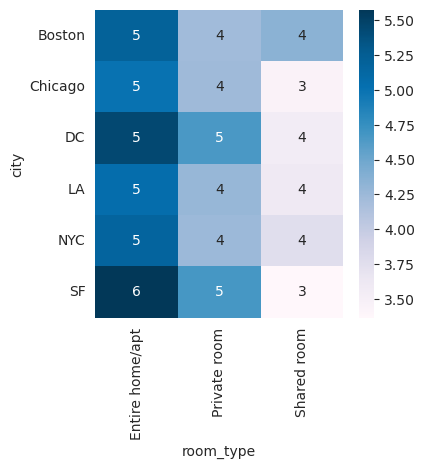

In [562]:
plt.figure(figsize=(4,4))
color4 = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_airbnb_train.groupby([
        'city', 'room_type']).log_price.mean().unstack(),annot=True, fmt=".0f",cmap=color3)

<Axes: xlabel='bedrooms', ylabel='property_type'>

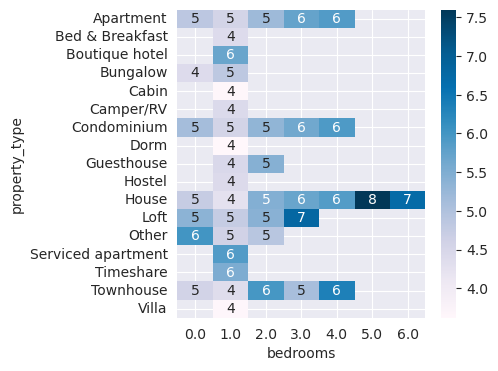

In [563]:
plt.figure(figsize=(4,4))
sns.heatmap(df_airbnb_train.groupby(['property_type', 'bedrooms']).log_price.mean().unstack(), annot=True, fmt=".0f",cmap=color3)

<Axes: xlabel='bedrooms', ylabel='property_type'>

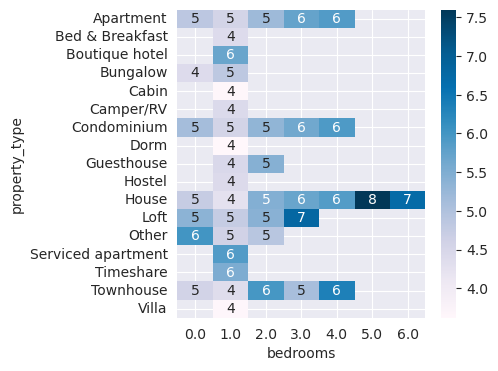

In [564]:
plt.figure(figsize=(4,4))
sns.heatmap(df_airbnb_train.groupby(['property_type', 'bedrooms']).log_price.mean().unstack(), annot=True, fmt=".0f",cmap=color3)

In [33]:
#¿Cómo está el campo amenities?
df_airbnb_train['amenities'].head(5)

0    [Internet, Wireless Internet, Air conditioning...
1    [Internet, Wireless Internet, Kitchen, Heating...
2    [TV, Cable TV, Internet, Wireless Internet, Ai...
3    [Internet, Wireless Internet, Air conditioning...
4    [TV, Internet, Wireless Internet, Air conditio...
Name: amenities, dtype: object

In [34]:
#Otra vez tenemos problemas con las variable amenities, la volvemos a transformar en lista
df_airbnb_train['amenities'] = df_airbnb_train['amenities'].apply(lambda x: [i.strip() for i in x])
#Confirmamos el tipo
df_airbnb_train.dtypes

id                          int32
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                 int8
bathrooms                 float32
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate        float64
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int32
review_scores_rating      float32
thumbnail_url              object
zipcode                    object
bedrooms                  float32
beds                      float32
dtype: object

In [35]:
#¿Esta relleno el campo de amenities?
df_airbnb_train['amenities'].head(5)

0    [Internet, Wireless Internet, Air conditioning...
1    [Internet, Wireless Internet, Kitchen, Heating...
2    [TV, Cable TV, Internet, Wireless Internet, Ai...
3    [Internet, Wireless Internet, Air conditioning...
4    [TV, Internet, Wireless Internet, Air conditio...
Name: amenities, dtype: object

In [101]:

# Cuenta el número de veces que aparece cada categoría en la lista
conteo = pd.Series(df_airbnb_train['amenities'].sum()).value_counts()

# Calcula el porcentaje de cada categoría en la lista
porcentajes =  (conteo/len(df_airbnb_train))*100 

In [102]:
conteo

Wireless Internet                    953
Heating                              907
Kitchen                              896
Essentials                           858
Smoke detector                       832
                                    ... 
EV charger                             1
Wide clearance to shower & toilet      1
Beachfront                             1
Handheld shower head                   1
Other                                  1
Length: 110, dtype: int64

In [103]:
porcentajes

Wireless Internet                    95.3
Heating                              90.7
Kitchen                              89.6
Essentials                           85.8
Smoke detector                       83.2
                                     ... 
EV charger                            0.1
Wide clearance to shower & toilet     0.1
Beachfront                            0.1
Handheld shower head                  0.1
Other                                 0.1
Length: 110, dtype: float64

In [94]:
# Cuenta el número total de categorías en la lista
#num_categorias = df_airbnb_train['amenities'].apply(len).nunique()
num_categorias = df_airbnb_train['amenities'].apply(len).nunique()
#num_categorias = df_airbnb_train.explode('amenities')['amenities'].unique()

# Cuenta el número de veces que aparece cada categoría en la lista
conteo = pd.Series(df_airbnb_train['amenities'].sum()).value_counts()

# Calcula el porcentaje de cada categoría en la lista
porcentajes =  (conteo/len(df_airbnb_train))*100 


In [91]:
#Número de categorías
conteo.size

110

<Figure size 4000x4000 with 0 Axes>

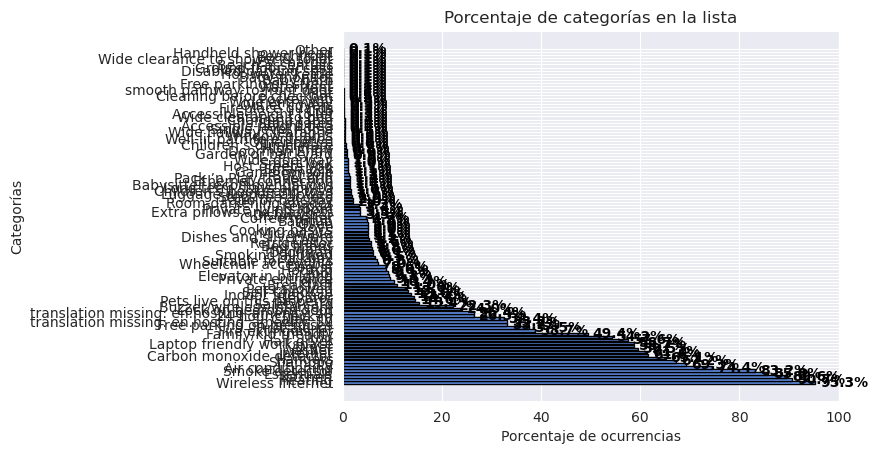

In [92]:
import matplotlib
plt.figure(figsize=(40,40))
fig, ax = plt.subplots()
ax.barh(conteo.index, porcentajes, color='cornflowerblue', edgecolor='black', linewidth=1)
ax.set_xlabel('Porcentaje de ocurrencias')
ax.set_ylabel('Categorías')
ax.set_title('Porcentaje de categorías en la lista')

# Agregar etiquetas de valor encima de cada barra en porcentaje
for i, v in enumerate(porcentajes):
    ax.text(v + 1, i, f'{v:.1f}%', color='black', fontweight='bold', ha='left', va='center')

plt.show()

Como se puede ver.....no se ve nada, igual que para el campo property_type, tendríamos que agrupar variables por afinindad o sino en un otros, debido al tiempo....optaremos por la solución sencilla...y sobre todo rápida. Tenemos 110 categorías.

In [87]:
conteo.info()

<class 'pandas.core.series.Series'>
Index: 110 entries, Wireless Internet to Other
Series name: None
Non-Null Count  Dtype
--------------  -----
110 non-null    int64
dtypes: int64(1)
memory usage: 5.8+ KB


Lo haremos de forma muy manual sin meter "mucho" conocimiento y con poco esfuerzo, lo suyo es hacerlo de forma fina....no estoy muy orgulloso de esto, pero es una pincelada de como luego haríamos un grafico, informando de que porcentaje de casos cumplen por ejemplo el tener Internet, Wireless Internet, Air conditioning,...

In [94]:
df_conteo = conteo.to_frame()

df_conteo.head(3)

,0
Wireless Internet,953
Heating,907
Kitchen,896


In [108]:
df_conteo = conteo.to_frame()

# Seleccionar las primeras 10 filas
df_top_15 = df_conteo.head(15)
serie_resultante = df_top_15[0]
serie_resultante[0:2]


Wireless Internet    953
Heating              907
Name: 0, dtype: int64

In [109]:
# Calcula el porcentaje de cada categoría en la lista
porcentajes_serie =  (serie_resultante/len(df_airbnb_train))*100 

<Figure size 4000x4000 with 0 Axes>

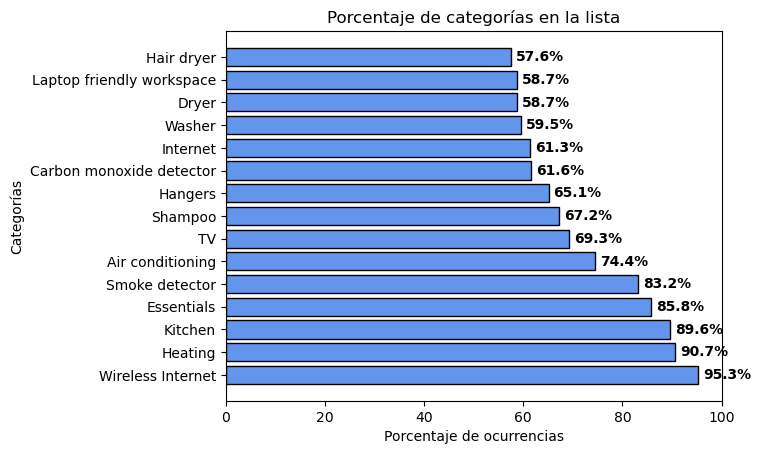

In [114]:
import matplotlib
plt.figure(figsize=(40,40))
fig, ax = plt.subplots()
ax.barh(serie_resultante.index, porcentajes[0:15], color='cornflowerblue', edgecolor='black', linewidth=1)
ax.set_xlabel('Porcentaje de ocurrencias')
ax.set_ylabel('Categorías')
ax.set_title('Porcentaje de categorías en la lista')

# Agregar etiquetas de valor encima de cada barra en porcentaje
for i, v in enumerate(porcentajes[0:15]):
    ax.text(v + 1, i, f'{v:.1f}%', color='black', fontweight='bold', ha='left', va='center')

plt.show()

Por lo que el 95,3% de los registros tienen el Wireless Internet, un 90,7% tienen Heating, un 89,6% tienen kitchen,...

In [ ]:
dddddddddddddddddddddddddd

#### Missing

In [70]:
   
def data_overview(df, corr=False, label_name=None, sort_by='qtd_null', thresh_percent_null=0, thresh_corr_label=0):


    # Criando DataFrame com informações de dados nulos
    df_null = pd.DataFrame(df.isnull().sum()).reset_index()
    df_null.columns = ['feature', 'qtd_null']
    df_null['percent_null (%)'] = (df_null['qtd_null'] / len(df))*100
    
    df_null.loc[df_null['percent_null (%)'] >=20, 'percent_null_alert_>=20%'] = 'Revisar % missing >20%' 
    df_null.loc[df_null['percent_null (%)'] < 20, 'percent_null_alert_>=20%'] = 'No revisar % missing <20%'

    # Retornando tipo primitivo e qtd de entradas para os categóricos
    df_null['dtype'] = df_null['feature'].apply(lambda x: df[x].dtype)
    df_null['número categorías'] = [len(df[col].value_counts()) if df[col].dtype == 'object' else 0 for col in
                          df_null['feature'].values]

    if corr:
        # Extraindo informação de correlação com o target
        label_corr = pd.DataFrame(df.corr()[label_name])
        label_corr = label_corr.reset_index()
        label_corr.columns = ['feature', 'target_pearson_corr']

        # Unindo informações
        df_null_overview = df_null.merge(label_corr, how='left', on='feature')
        df_null_overview.query('target_pearson_corr > @thresh_corr_label')
    else:
        df_null_overview = df_null

    # Filtrando dados nulos de acordo com limiares
    #df_null_overview.query(''percent_null (%)' > @thresh_percent_null')

    # Ordenando DataFrame
    df_null_overview = df_null_overview.sort_values(by=sort_by, ascending=False)
    df_null_overview = df_null_overview.reset_index(drop=True)

    return df_null_overview

In [72]:
#Generación de df con missing
data_overview(df_airbnb_train)

,feature,qtd_null,percent_null (%),percent_null_alert_>=20%,dtype,número categorías
0,host_response_rate,249,24.9,Revisar % missing >20%,float64,0
1,review_scores_rating,241,24.1,Revisar % missing >20%,float32,0
2,first_review,226,22.6,Revisar % missing >20%,object,573
3,last_review,225,22.5,Revisar % missing >20%,object,322
4,thumbnail_url,103,10.3,No revisar % missing <20%,object,897
5,neighbourhood,89,8.9,No revisar % missing <20%,object,251
6,zipcode,14,1.4,No revisar % missing <20%,object,313
7,bathrooms,3,0.3,No revisar % missing <20%,float32,0
8,host_identity_verified,1,0.1,No revisar % missing <20%,object,2
9,bedrooms,1,0.1,No revisar % missing <20%,float32,0


#### Tendríamos que hacer también la validación del conjunto de test e importante comprobar que las distribuciones de las variables son similares en train y test, ya que al hacer las validades de los modelos en el conjunto de test sean coherentes y sobre todo correctas.

In [73]:
#Método que permite crear una vista temporal de una tabla en la sesión de Spark actual
#Cuando se llama a createOrReplaceTempView(), se le da un nombre a la vista temporal y se asocia con una tabla

airbnb_train.createOrReplaceTempView("airbnb_train")
airbnb_test.createOrReplaceTempView("airbnb_test")

In [262]:
#Otra forma de ver duplicados....
duplis = spark.sql("""
                SELECT id, count(*) as publicaciones 
                FROM airbnb_train

                GROUP BY 1
                having count(*)>1
                """)
duplis.show()

+---+-------------+
| id|publicaciones|
+---+-------------+
+---+-------------+



In [263]:
airbnb_train.filter(airbnb_train.id.isNull()).show()

+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------------+-----------------+--------------------+-------------+-------+--------+----+
| id|log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|latitude|longitude|name|neighbourhood|number_of_reviews|review_scores_rating|thumbnail_url|zipcode|bedrooms|beds|
+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------

### Consultas

#### Consulta 1. Identifica las 10 entradas con mayor precio en el dataset train.csv junto con la ciudad en la que está ubicada cada una de ellas.  

#### ¿Cuántas entradas de este dataset crees que se pueden considerar extremadamente caras (datos atípicos con valores muy altos)? Para razonar tu respuesta, puedes representar un histograma o un diagramade densidad de probabilidad de los precios del dataset.

In [264]:
# Consulta sin SQL
consulta1 = spark.sql("""
                SELECT city, log_price 
                FROM airbnb_train
                ORDER BY 2 DESC
                LIMIT 10
                """)
consulta1.show()

+----+-----------------+
|city|        log_price|
+----+-----------------+
|  LA|  7.6004023345004|
| NYC|  7.6004023345004|
| NYC|  7.6004023345004|
|  DC|  7.6004023345004|
|  DC|  7.6004023345004|
|  LA|7.598399329323964|
|  LA|7.598399329323964|
|  SF|7.598399329323964|
|  DC|7.598399329323964|
|  LA|7.598399329323964|
+----+-----------------+



In [265]:
# Consulta sin SQL
(airbnb_train.select('city','log_price')
         .orderBy(desc('log_price'))
         .limit(10)
         .show())

+----+-----------------+
|city|        log_price|
+----+-----------------+
|  LA|  7.6004023345004|
| NYC|  7.6004023345004|
| NYC|  7.6004023345004|
|  DC|  7.6004023345004|
|  DC|  7.6004023345004|
|  LA|7.598399329323964|
|  LA|7.598399329323964|
|  SF|7.598399329323964|
|  DC|7.598399329323964|
|  LA|7.598399329323964|
+----+-----------------+



In [276]:
#Para evaluar los atipicos es mejor transformar a su variable original, ya que el logaritmo ayuda a normalizar la variale de precio
airbnb_train = airbnb_train.withColumn("price", exp(airbnb_train['log_price']))

In [277]:
airbnb_train.select('log_price','price').describe().toPandas()

,summary,log_price,price
0,count,74111,74111
1,mean,4.782069108304868,160.37084913170784
2,stddev,0.7173937845081529,168.58041526376712
3,min,0.0,1.0
4,max,7.6004023345004,1998.9999999999993


In [292]:
#Obtenemos percentiles...
percentiles = [0.25, 0.5, 0.75,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99]
resultados= airbnb_train.select('log_price').approxQuantile('log_price', percentiles, 0.01)


# Unir las listas de percentiles y valores correspondientes
pares_percentil_valor = list(zip(percentiles, resultados ))
pares_percentil_valor

[(0.25, 4.31748811353631),
 (0.5, 4.700480365792417),
 (0.75, 5.220355825078324),
 (0.9, 5.68697535633982),
 (0.92, 5.783825182329737),
 (0.94, 5.863631175598098),
 (0.95, 5.991464547107983),
 (0.96, 6.100318952020063),
 (0.97, 6.214608098422191),
 (0.98, 6.395261598115449),
 (0.99, 7.6004023345004)]

In [293]:
#Obtenemos percentiles...
percentiles = [0.25, 0.5, 0.75,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99]
resultados= airbnb_train.select('price').approxQuantile('price', percentiles, 0.01)


# Unir las listas de percentiles y valores correspondientes
pares_percentil_valor = list(zip(percentiles, resultados ))
pares_percentil_valor

[(0.25, 74.99999999999997),
 (0.5, 110.00000000000004),
 (0.75, 184.99999999999991),
 (0.9, 295.0000000000001),
 (0.92, 324.99999999999994),
 (0.94, 352.0000000000002),
 (0.95, 400.0000000000002),
 (0.96, 445.99999999999966),
 (0.97, 499.99999999999983),
 (0.98, 599.0),
 (0.99, 1998.9999999999993)]

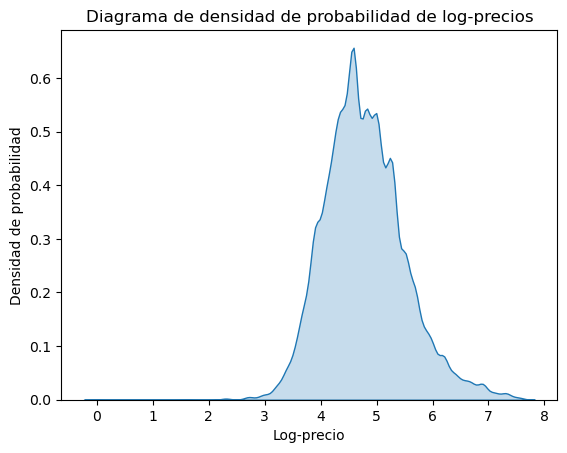

In [280]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

price_list = airbnb_train.select(col('log_price')).rdd.flatMap(lambda x: x).collect()

sns.kdeplot(price_list, fill=True)
plt.xlabel('Log-precio')
plt.ylabel('Densidad de probabilidad')
plt.title('Diagrama de densidad de probabilidad de log-precios')
plt.show()

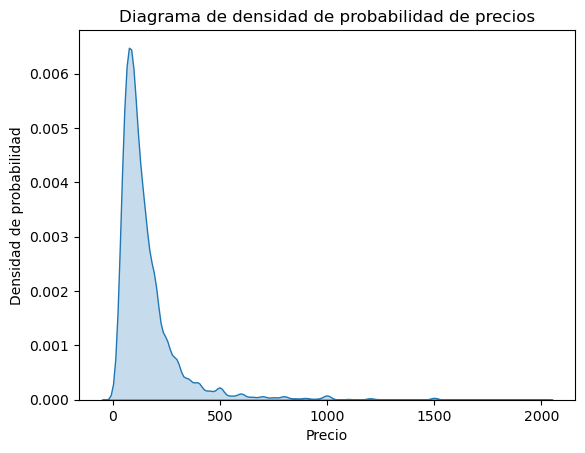

In [281]:
price_list = airbnb_train.select(col('price')).rdd.flatMap(lambda x: x).collect()

sns.kdeplot(price_list, fill=True)
plt.xlabel('Precio')
plt.ylabel('Densidad de probabilidad')
plt.title('Diagrama de densidad de probabilidad de precios')
plt.show()

Al ver el precio con el logaritmo es más dificil de ver los casos outliers, por eso hemos transformado la variable a su valor original, con la exponencial y así se ve más claro y gracias a los gráficos y a los percentiles más claro todavía.  

Considero que aproximadamente los valores de precio superiores al percentil 97 son atípicos, es decir valores superiores a 500 y habrá como 2.220 casos aproximadamente.



#### Consulta 2. Calcula el número total de entradas que indican la etiqueta “Wireless Internet” en el campo amenities.
#### Después, repite la misma consulta, pero ahora desglosando los resultados de número total de entradas que incluyen esa etiqueta por cada ciudad.

In [349]:
#Se podría hacer en un paso....pero para verlo mejor.... 
wireless_df = airbnb_train.select("city",explode(col("amenities")).alias("amenities_v2"))

# Filtrar las entradas que contienen "Wireless Internet"
wi_df = wireless_df. filter(wireless_df.amenities_v2 == "Wireless Internet").count()

print(f"Wireless Internet aparece {wi_df}")

Wireless Internet aparece 71265


In [352]:
wireless_df_city = (
    wireless_df.
    filter(col("amenities_v2") == "Wireless Internet").
    groupBy("city").
    agg(count('amenities_v2').alias("Numero_de_casos")).
    orderBy(desc("Numero_de_casos"))
   )


wireless_df_city.show()

#filter(col("amenities_v2") == "Wireless Internet"). y where(col("amenities_v2") == "Wireless Internet"). son similares

+-------+---------------+
|   city|Numero_de_casos|
+-------+---------------+
|    NYC|          31304|
|     LA|          21351|
|     SF|           6214|
|     DC|           5472|
|Chicago|           3576|
| Boston|           3348|
+-------+---------------+



#### Consulta 3. Obtén las 2 ciudades en el dataset train.csv con mayor número total de entradas publicadas ubicadas en ellas, excluyendo NYC y LA. Compara esta lista con la de las 2 ciudades que cumplen la misma condición en el dataset test.csv (de nuevo, excluyendo NYC y LA)

In [300]:
#airbnb_train.select("city").distinct().show()

In [310]:
consulta3_train = spark.sql("""
                SELECT city, count(*) as publicaciones 
                FROM airbnb_train
                WHERE city not in ("NYC","LA")
                GROUP BY 1
                ORDER BY 2 desc
                LIMIT 2
                """)
consulta3_train.show()

+----+-------------+
|city|publicaciones|
+----+-------------+
|  SF|         6434|
|  DC|         5688|
+----+-------------+



In [311]:
consulta3_test = spark.sql("""
                SELECT city, count(*) as publicaciones 
                FROM airbnb_test
                WHERE city not in ("NYC","LA")
                GROUP BY 1
                ORDER BY 2 desc
                LIMIT 2
                """)
consulta3_test.show()

+----+-------------+
|city|publicaciones|
+----+-------------+
|  SF|         2237|
|  DC|         1874|
+----+-------------+



Tanto en train como test coinciden las dos ciudades con más publicaciones, para para tener un visión más global tendríamos que ver si las distribución de la variale city son similares en train y test

In [312]:
#Distribución de la variabe city para train
total_count_train = airbnb_train.count()
consulta3_train = spark.sql("""
                SELECT city, count(*) as publicaciones 
                FROM airbnb_train
                GROUP BY 1
                ORDER BY 2 desc
                """)

consulta3_train = consulta3_train.withColumn("porcentaje (%)", round((consulta3_train["publicaciones"]/total_count_train)*100,2) )

consulta3_train.show()

+-------+-------------+--------------+
|   city|publicaciones|porcentaje (%)|
+-------+-------------+--------------+
|    NYC|        32349|         43.65|
|     LA|        22453|          30.3|
|     SF|         6434|          8.68|
|     DC|         5688|          7.67|
|Chicago|         3719|          5.02|
| Boston|         3468|          4.68|
+-------+-------------+--------------+



In [313]:
#Distribución de la variabe city para test
total_count_test = airbnb_test.count()
consulta3_test = spark.sql("""
                SELECT city, count(*) as publicaciones 
                FROM airbnb_test

                GROUP BY 1
                ORDER BY 2 desc
                """)

consulta3_test = consulta3_test.withColumn("porcentaje  (%)", round((consulta3_test["publicaciones"]/total_count_test)*100,2) )

consulta3_test.show()

+-------+-------------+---------------+
|   city|publicaciones|porcentaje  (%)|
+-------+-------------+---------------+
|    NYC|        11049|           43.4|
|     LA|         7758|          30.47|
|     SF|         2237|           8.79|
|     DC|         1874|           7.36|
|Chicago|         1365|           5.36|
| Boston|         1175|           4.62|
+-------+-------------+---------------+



Comprobamos que las distribuciones de la variable city en train y test de la variable city son similares.

#### Consulta 4. Ordena cronológicamente (del valor más antiguo al más reciente) usando el campo last_review todas las entradas ubicadas en la ciudad de Boston y calcula el intervalo de tiempo entre cada dos filas consecutivas utilizando dicho campo.

#### ¿Crees que fluctúa mucho el valor de esos intervalos? Para razonar tu respuesta, pudes analizar gráficamente la distribución de duraciones de los intervalos solicitados.

In [353]:
# Filtramos los casos de Bosto y aquellas que las_revier no sean nulos
consulta4 = spark.sql("""
                SELECT *
                FROM airbnb_train
                WHERE city in ("Boston") and last_review is not null
                ORDER BY last_review

                """)
#consulta4.show(vertical=True)

In [354]:
#.cast(DayTimeIntervalType())

#from pyspark.sql.functions import lag, datediff
from pyspark.sql.window import Window

# Agregar una columna que contenga el valor de "last_review" de la fila anterior utilizando la función lag()
w = Window.partitionBy("city").orderBy("last_review")
consulta4 = consulta4.withColumn("anterior_last_review", lag("last_review").over(w))

# Calcular la diferencia de días entre la fecha de "last_review" y la fecha de "anterior_last_review"
consulta4 = consulta4.withColumn("diferencia_dias", datediff(consulta4["last_review"], consulta4["anterior_last_review"]))

# Mostrar los resultados
consulta4.select("last_review", "anterior_last_review","diferencia_dias").show(8,vertical=True)
consulta4.count()

-RECORD 0--------------------------
 last_review          | 2010-11-04 
 anterior_last_review | null       
 diferencia_dias      | null       
-RECORD 1--------------------------
 last_review          | 2013-06-02 
 anterior_last_review | 2010-11-04 
 diferencia_dias      | 941        
-RECORD 2--------------------------
 last_review          | 2014-06-22 
 anterior_last_review | 2013-06-02 
 diferencia_dias      | 385        
-RECORD 3--------------------------
 last_review          | 2014-07-02 
 anterior_last_review | 2014-06-22 
 diferencia_dias      | 10         
-RECORD 4--------------------------
 last_review          | 2014-08-02 
 anterior_last_review | 2014-07-02 
 diferencia_dias      | 31         
-RECORD 5--------------------------
 last_review          | 2014-08-09 
 anterior_last_review | 2014-08-02 
 diferencia_dias      | 7          
-RECORD 6--------------------------
 last_review          | 2014-08-09 
 anterior_last_review | 2014-08-09 
 diferencia_dias      | 0   

2847

In [253]:
consulta4.select('diferencia_dias').describe().toPandas()

,summary,diferencia_dias
0,count,2846
1,mean,0.8879128601546029
2,stddev,19.16643635818075
3,min,0
4,max,941


In [356]:
#Obtenemos percentiles...
percentiles = [0.25, 0.5, 0.75,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99]
resultados= consulta4.select('diferencia_dias').approxQuantile('diferencia_dias', percentiles, 0.01)


# Unir las listas de percentiles y valores correspondientes
pares_percentil_valor = list(zip(percentiles, resultados ))
pares_percentil_valor

[(0.25, 0.0),
 (0.5, 0.0),
 (0.75, 0.0),
 (0.9, 1.0),
 (0.92, 1.0),
 (0.94, 1.0),
 (0.95, 1.0),
 (0.96, 2.0),
 (0.97, 2.0),
 (0.98, 3.0),
 (0.99, 941.0)]

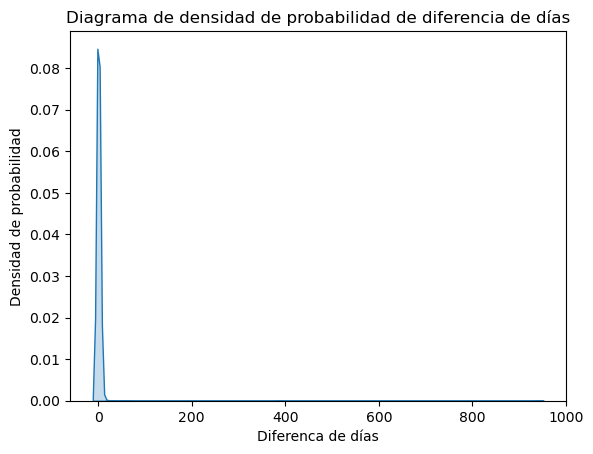

In [300]:
#Aunque parezca que no se ve nada con este gráfico, algo se ve, ves el gran pico a la izquiera y a la derecha nada, pero si hay pocos casos..
# Pero vamos a verlo con otro gráfico de una forma más evidente
sns.kdeplot(consulta4.select('diferencia_dias').toPandas()['diferencia_dias'], fill=True)
plt.xlabel('Diferenca de días')
plt.ylabel('Densidad de probabilidad')
plt.title('Diagrama de densidad de probabilidad de diferencia de días')
plt.show()

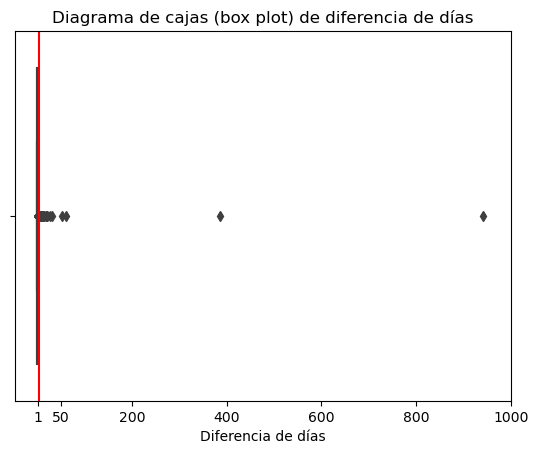

In [374]:
# Crear el boxplot utilizando seaborn
pandas_df = consulta4.select('diferencia_dias').toPandas()
import numpy as np 
# Crear el boxplot utilizando seaborn
sns.boxplot(x="diferencia_dias", data=pandas_df)
plt.xlabel('Diferencia de días')
ticks = [1]+[50] + list(range(200, 1001, 200))
plt.xticks(ticks)
#plt.xticks(np.arange(0, 1000, step=50))
plt.title('Diagrama de cajas (box plot) de diferencia de días')

# Agregar una línea vertical en el valor 3
plt.axvline(x=3, color='r')

plt.show()


Tanto como el gráfico de cajas y con los percentiles se ve claramente que hay una concentración en valores pequeños, por lo que hay poca fluctuación (el 98% de los casos se concentran en los valores de 1 a 3 días de diferencia)

#### Consulta 5. Recupera aquellas entradas de todo el dataset train.csv que tienen un valor inferior o igual a 30.0 para el campo review_scores_rating. ¿Cuál es el número de reseñas (number_of_reviews) máximo, mínimo y promedio que tienen esas entradas? ¿Qué valores de cleaning_fee y cancellation_policy tienen esas entradas? Razona si, a la vista de los resultados, se puede realizar alguna deducción sobre las características de las entradas con peores scores de este dataset.

In [89]:
%%time
consulta5 = spark.sql("""
                SELECT sum(number_of_reviews) as suma_number_of_reviews,
                max(number_of_reviews) as maximo ,min(number_of_reviews) as minimo, avg(number_of_reviews) as media,
                count(*) as n
                FROM airbnb_train
                WHERE (review_scores_rating) IS NOT NULL and  (review_scores_rating) <= 30.0 and (review_scores_rating) > 0.0

                """)


# En la consulta como tal, no haría falta poner en el where (review_scores_rating) IS NOT NULL
#, pero compruebo que tarda menos la consulta

consulta5.show()


+----------------------+------+------+------------------+---+
|suma_number_of_reviews|maximo|minimo|             media|  n|
+----------------------+------+------+------------------+---+
|                   134|     5|     1|1.3009708737864079|103|
+----------------------+------+------+------------------+---+

CPU times: user 2.38 ms, sys: 10.6 ms, total: 13 ms
Wall time: 8.75 s


Consulta política de cancelación y tarifa de limpieza

In [85]:
%%time
# Ahora sin SQL para cancellation_policy

consulta5_1 = (
    airbnb_train.
    where((col('review_scores_rating') >= 0) & (col('review_scores_rating') <= 30)).
    groupBy("cancellation_policy").
    agg(
        min("number_of_reviews").alias("min_number_of_reviews"),
        max("number_of_reviews").alias("max_number_of_reviews"),
        avg("number_of_reviews").alias("promedio_number_of_reviews"),
        sum("number_of_reviews").alias("sum_number_of_reviews"),
        avg("review_scores_rating").alias("promedio_review"),
        count("number_of_reviews").alias("counts"),
    )
)
consulta5_1.show()

+-------------------+---------------------+---------------------+--------------------------+---------------------+-----------------+------+
|cancellation_policy|min_number_of_reviews|max_number_of_reviews|promedio_number_of_reviews|sum_number_of_reviews|  promedio_review|counts|
+-------------------+---------------------+---------------------+--------------------------+---------------------+-----------------+------+
|           flexible|                    1|                    5|        1.3725490196078431|                   70|20.58823529411765|    51|
|    super_strict_60|                    1|                    1|                       1.0|                    1|             20.0|     1|
|             strict|                    1|                    3|        1.1714285714285715|                   41|             20.4|    35|
|           moderate|                    1|                    3|                     1.375|                   22|           20.625|    16|
+-------------------

In [79]:
%%time
#Ahora con SQL para cancellation_policy
consulta5_1_sql = spark.sql("""
                SELECT cancellation_policy, sum(number_of_reviews) as suma_number_of_reviews,
                max(number_of_reviews) as maximo ,min(number_of_reviews) as minimo, avg(number_of_reviews) as media,
                avg(review_scores_rating) as media_review_scores_rating,
                 count(*) as n
                
                FROM airbnb_train
                WHERE (review_scores_rating) IS NOT NULL and (review_scores_rating) > 0.0 AND (review_scores_rating) <= 30.0
                group by 1

                """)
consulta5_1_sql.show()

+-------------------+----------------------+------+------+------------------+--------------------------+---+
|cancellation_policy|suma_number_of_reviews|maximo|minimo|             media|media_review_scores_rating|  n|
+-------------------+----------------------+------+------+------------------+--------------------------+---+
|           flexible|                    70|     5|     1|1.3725490196078431|         20.58823529411765| 51|
|    super_strict_60|                     1|     1|     1|               1.0|                      20.0|  1|
|             strict|                    41|     3|     1|1.1714285714285715|                      20.4| 35|
|           moderate|                    22|     3|     1|             1.375|                    20.625| 16|
+-------------------+----------------------+------+------+------------------+--------------------------+---+

CPU times: user 8.07 ms, sys: 10 ms, total: 18.1 ms
Wall time: 11.3 s


In [86]:
%%time
#Ahora sin SQL para cleaning_fee
consulta5_2 = (
    airbnb_train.
    where((col('review_scores_rating') >= 0) & (col('review_scores_rating') <= 30)).
    groupBy("cleaning_fee").
    agg(
        
        min("number_of_reviews").alias("min_number_of_reviews"),
        max("number_of_reviews").alias("max_number_of_reviews"),
        avg("number_of_reviews").alias("promedio_number_of_reviews"),
        sum("number_of_reviews").alias("sum_number_of_reviews"),
        avg("review_scores_rating").alias("promedio_review"),
        count("number_of_reviews").alias("count"),
    )
)
consulta5_2.show()

+------------+---------------------+---------------------+--------------------------+---------------------+-----------------+-----+
|cleaning_fee|min_number_of_reviews|max_number_of_reviews|promedio_number_of_reviews|sum_number_of_reviews|  promedio_review|count|
+------------+---------------------+---------------------+--------------------------+---------------------+-----------------+-----+
|        true|                    1|                    3|        1.2586206896551724|                   73|20.46551724137931|   58|
|       false|                    1|                    5|        1.3555555555555556|                   61|             20.6|   45|
+------------+---------------------+---------------------+--------------------------+---------------------+-----------------+-----+

CPU times: user 44.4 ms, sys: 9.4 ms, total: 53.8 ms
Wall time: 9.49 s


In [87]:
%%time
#Ahora con SQL para cleaning_fee
consulta5_2_sql = spark.sql("""
                SELECT cleaning_fee, sum(number_of_reviews) as suma_number_of_reviews,
                max(number_of_reviews) as maximo ,min(number_of_reviews) as minimo, avg(number_of_reviews) as media,
                avg(review_scores_rating) as media_review_scores_rating,
                count(*) as n
                FROM airbnb_train
                WHERE (review_scores_rating) IS NOT NULL and (review_scores_rating) > 0.0 AND (review_scores_rating) <= 30.0
                group by 1

                """)
consulta5_2_sql.show()

+------------+----------------------+------+------+------------------+--------------------------+---+
|cleaning_fee|suma_number_of_reviews|maximo|minimo|             media|media_review_scores_rating|  n|
+------------+----------------------+------+------+------------------+--------------------------+---+
|        true|                    73|     3|     1|1.2586206896551724|         20.46551724137931| 58|
|       false|                    61|     5|     1|1.3555555555555556|                      20.6| 45|
+------------+----------------------+------+------+------------------+--------------------------+---+

CPU times: user 12.6 ms, sys: 298 µs, total: 12.9 ms
Wall time: 8.66 s


Antes de meternos en las deducciones, vemos que las consultas de SQL tardan menos en obtener los resultados

**La política de cancelación de la poliza moderada tiene un promedio de 1,375 reseñas y la flexible 1,372, cifras superiores a la estricta 1,17 (para la super esctricta, sólo hay un caso) es un poco extraño este hecho, puede ser que haya casuísticas en las cuales en la cancelacioón moderada y flexible esté dando problemas, que se estén quejando por tener problemas en las cancelaciones**

**Y en cuanto a los que tienen tarifa de limpieza tienen menor promedio de reseñas, 1,258 vs los que no tienen tarifa de limpieza 1,355, pero si vemos los casos que tienen reseñas es superior los casos que no tienen tarifa, por lo que puede haber casos que se estén quejando de las condiciones de esa tarif de limpieza**

Tablas para ratios superiores a 30 por si veo algo diferente al inferior....no veo nada en la comparativa

In [ ]:
%%time
#Ahora con SQL para cleaning_fee
consulta5_2_mayor30 = spark.sql("""
                SELECT cleaning_fee, sum(number_of_reviews) as suma_number_of_reviews,
                max(number_of_reviews) as maximo ,min(number_of_reviews) as minimo, avg(number_of_reviews) as media,
                avg(review_scores_rating) as media_review_scores_rating,  count(*) as n
                FROM airbnb_train
                WHERE (review_scores_rating) IS NOT NULL  and (review_scores_rating > 30.0)
                group by 1

                """)
consulta5_2_mayor30.show()

+------------+----------------------+------+------+------------------+--------------------------+-----+
|cleaning_fee|suma_number_of_reviews|maximo|minimo|             media|media_review_scores_rating|    n|
+------------+----------------------+------+------+------------------+--------------------------+-----+
|        true|               1272163|   542|     1|27.947341827768014|         94.30046133567663|45520|
|       false|                274757|   605|     1|23.351776304606492|         93.80936596974333|11766|
+------------+----------------------+------+------+------------------+--------------------------+-----+

CPU times: user 10.2 ms, sys: 1.28 ms, total: 11.4 ms
Wall time: 10.4 s


In [ ]:
%%time
#Ahora con SQL para cleaning_fee
consulta5_2_mayor30 = spark.sql("""
                SELECT cancellation_policy, sum(number_of_reviews) as suma_number_of_reviews,
                max(number_of_reviews) as maximo ,min(number_of_reviews) as minimo, avg(number_of_reviews) as media,
                avg(review_scores_rating) as media_review_scores_rating,  count(*) as n
                FROM airbnb_train
                WHERE (review_scores_rating) IS NOT NULL  and (review_scores_rating > 30.0)
                group by 1

                """)
consulta5_2_mayor30.show()